## Project Milestone 4 - Linguistic Harbingers of Betrayal Extension Part I

In this notebook, we consider each valuable season as individual. We process the data in the way like in part 4 of the paper *Language Foretelling Betrayal*.  

Given the messages sent by a player from a season in a game, we need to calculate the different variable values of the messages. 

Based on the feature selection we did, variables we consider:

1. sent_pos: Positive sentiment
2. sent_neu: Neutral sentiment
3. sent_neg: Negative sentiment
4. discourse_comp: Discourse complexity (calculated through comparison, contingency, expansive, sum those values)
5. plan: Planning level (calculated through future)
6. argu_claim: Argumentation level calculated through claim
7. argu_premise: Argumentation level calculated through premise
8. n_request: Number of requests
9. politeness: Politeness
10. n_words: Number of words
11. n_sentences: Number of sentences

First, input all the libraries we need:

In [18]:
import json
from sklearn.metrics import roc_curve, auc 
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import networkx as nx
import math
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score


Since the data file contains only the selected games, there is no need to consider the selection criteria when retreving the message data. 
*The condition "relationships that contain at least two consecutive and reciprocated acts of support that span at least three seasons in game time, with no more than five seasons passing between two acts of friendship" is fullfilled.

Here, we read the data from json file and get the number of games, which is 500, including 250 selected games ended up betrayal and 250 selected games ended up lasting friendship between two players.


In [5]:
# read data from diplomacy_data.json with reading mode
with open("diplomacy_data.json", "r") as f:
        data = json.load(f)
len(data)

500

Since we only consider dialogs that happen before the last act of friendship, we need to know when does the last act of friendship happen. Later when extracting feature values, extract them from the seasons that is before the last support season.

In [6]:
# a function to get the season where the last support between two players happened
# entry refer to one entry in the dataset, one game
def last_support(entry):
    seasons = entry['seasons']
    last_support = None
    for season in seasons[:-1]:
        if 'support' in season['interaction'].values():
            last_support = season['season']
    return last_support

In [7]:
# a function to get the average value across the seasons for all features of the messages
# msgs: messages sent by a player from a season in a game
def extract_features(msgs):
    n_sents = sum(m['n_sentences'] for m in msgs) * 1.0
    if(n_sents==0.0):
        print(msgs)
    
    # Sentiment
    # compute positive sentiment score
    sent_pos = sum(m['sentiment'].get("positive") for m in msgs) / len(msgs)
    # compute neutral sentiment score
    sent_neu = sum(m['sentiment'].get("neutral") for m in msgs) / len(msgs)
    # compute positive sentiment score
    sent_neg = sum(m['sentiment'].get("negative") for m in msgs) / len(msgs)
    
    # Argumentation and Discourse
    # compute discourse complexity through comparison, contingency, expansive and temporal
    comparison = sum(len(m['lexicon_words'].get("disc_comparison", []))for m in msgs) / n_sents
    contingency = sum(len(m['lexicon_words'].get("disc_contingency", []))for m in msgs) / n_sents
    expansive = sum(len(m['lexicon_words'].get("disc_expansion", []))for m in msgs) / n_sents
    discourse_comp = comparison+contingency+expansive
    
    # compute the average number of markers refer to future
    plan = sum(len(m['lexicon_words'].get("disc_temporal_future", []))for m in msgs) / n_sents
    
    # compute argumentation level through claim and premise
    argu_claim = sum(len(m['lexicon_words'].get("claim", []))for m in msgs) / n_sents
    argu_premise = sum(len(m['lexicon_words'].get("premise", []))for m in msgs) / n_sents
    
    # compute average number of request
    n_request = sum(m['n_requests'] for m in msgs) / len(msgs)
    
    # Politeness
    politeness = sum(m['politeness'] for m in msgs) / len(msgs)
    
    # Talkativeness
    # compute average number of words
    n_words = sum(m['n_words'] for m in msgs) / len(msgs)
    # compute average number of sentences
    n_sentences = sum(m['n_sentences'] for m in msgs) / len(msgs)

    return np.array([sent_pos, sent_neu, sent_neg, discourse_comp, plan, argu_claim, argu_premise, n_request, politeness, n_words, n_sentences])

From paper: To ensure that we are studying conversational patterns that occur only when the two individuals in the dyad are ostensibly being friends, we only extract features from the messages exchanged before the last act of friendship.
Therefore, the messages we extract should from seasons less than last support season.

In [8]:
# a function to get average politeness scores from dataset entries 
# data: the dataset where we extract politeness score from
# betrayal: if the games we consider end up betrayal
# betrayer: if the person to be analyzed is the (potential) betrayer
def process_data(data, betrayal, betrayer):
    results = []

    # loop in every game in data
    for entry in data:                        
        if(entry['betrayal'] == betrayal):
            for i, season in enumerate(entry['seasons']):
                if(season['season'] <= last_support(entry)):
                    if(len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0):                
                        if(betrayer):
                            results.append(extract_features(season['messages']['betrayer']))
                        else:
                            results.append(extract_features(season['messages']['victim']))
       

    # return value is a list of features of the indicated player in the indicated type of games
    return results

Get the politeness score of the four conditions below:

In [9]:
# for the games end up betrayal, get politeness score for each betrayer
betray_er = pd.DataFrame(process_data(data, True, True))

# for the games end up betrayal, get politeness score for each victim
betray_vi = pd.DataFrame(process_data(data, True, False)) 

# for the games not end up betrayal, get politeness score for each potential betrayer
control_er = pd.DataFrame(process_data(data, False, True))

# for the games not end up betrayal, get politeness score for each potential victim
control_vi = pd.DataFrame(process_data(data, False, False)) 

In [10]:
# compute imbalance score of both betrayal and control games, concat them to get a dataframe for betrayal prediction
betray_imb = betray_er-betray_vi
betray_imb['betray'] = 1
control_imb = control_er-control_vi
control_imb['betray'] = 0

frames = [betray_imb, control_imb]
Imbalance = pd.concat(frames,ignore_index=True)
Imbalance = Imbalance.rename(columns={0: "sent_pos", 1: "sent_neu", 2: "sent_neg", 3: "discourse_comp", 4: "plan", 5: "argu_claim", 6: "argu_premise", 7: "n_request", 8: "politeness", 9: "n_words", 10:"n_sentences"})
Imbalance

,sent_pos,sent_neu,sent_neg,discourse_comp,plan,argu_claim,argu_premise,n_request,politeness,n_words,n_sentences,betray
0,-0.166667,0.083333,-3.500000,0.237419,-0.009032,-0.024516,-0.332903,0.416667,-0.006665,-38.500000,-3.583333,1
1,-1.190476,0.190476,0.285714,0.312500,0.125000,0.062500,0.076389,0.619048,-0.225425,9.000000,-0.714286,1
2,1.000000,-1.166667,-2.666667,1.052198,0.271978,0.307692,-0.060440,1.833333,0.375372,46.500000,-2.833333,1
3,0.800000,0.800000,0.200000,0.083333,-0.125000,-0.125000,-0.083333,2.700000,0.177667,61.800000,1.800000,1
4,0.333333,-0.666667,-1.666667,0.133333,0.033333,-0.066667,0.133333,-0.333333,0.335738,-46.333333,-2.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1377,-1.000000,-0.500000,-1.500000,-0.625000,-0.375000,-0.250000,-0.250000,0.000000,-0.419398,-30.000000,-3.000000,0
1378,1.000000,5.000000,1.000000,0.250000,0.000000,0.125000,0.250000,2.000000,0.459459,101.000000,7.000000,0
1379,2.000000,4.000000,6.000000,0.500000,0.250000,0.000000,0.687500,6.000000,0.053745,249.000000,12.000000,0
1380,-2.000000,3.000000,5.000000,0.888889,0.333333,0.111111,0.444444,6.000000,0.027826,195.000000,6.000000,0


In [11]:
# seperate the dataset to train and test dataset at ratio 8:2
train, test = train_test_split(Imbalance, test_size=0.2, random_state=0)
trainX = train.drop(['betray'],axis=1)
trainy = train['betray']
testX = test.drop(['betray'],axis=1)
testy = test['betray']

We fit a logistic regression using the training dataset. We consider the p value of each variable to decide if the variable is important. However, we realize no matter how we try, the p value of some variables are still very high. The model we show here is the one with the highest predictive power, but we cannot really explain it since the p values are quite big. We therefore consider other models to do the prediction.

In [12]:
# use logistic regression to predict betrayal 
mod = smf.logit(formula='betray ~ sent_pos+sent_neu+sent_neg+discourse_comp*plan+argu_claim:argu_premise+argu_premise+n_request+politeness+n_words+n_words:n_sentences', data=train)
res = mod.fit(maxiter=30)
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.678994
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 betray   No. Observations:                 1105
Model:                          Logit   Df Residuals:                     1092
Method:                           MLE   Df Model:                           12
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                 0.01732
Time:                        22:55:16   Log-Likelihood:                -750.29
converged:                       True   LL-Null:                       -763.51
Covariance Type:            nonrobust   LLR p-value:                  0.009257
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.1401      0.066     -2.122      0.034      -0.270   

Check the predictive power of the logistic regression model:

In [13]:
# predict for test set
prob = res.predict(exog = testX)
pred = np.where(prob >= 0.45, 1, 0)

# compute confusion matrix
cm = metrics.confusion_matrix(testy, pred, labels=[0,1])
cm

array([[58, 72],
       [48, 99]])

In [14]:
# compute the accuracy of the model
accuracy = cm.diagonal().sum()/cm.sum()
accuracy

0.5667870036101083

<Figure size 432x288 with 0 Axes>

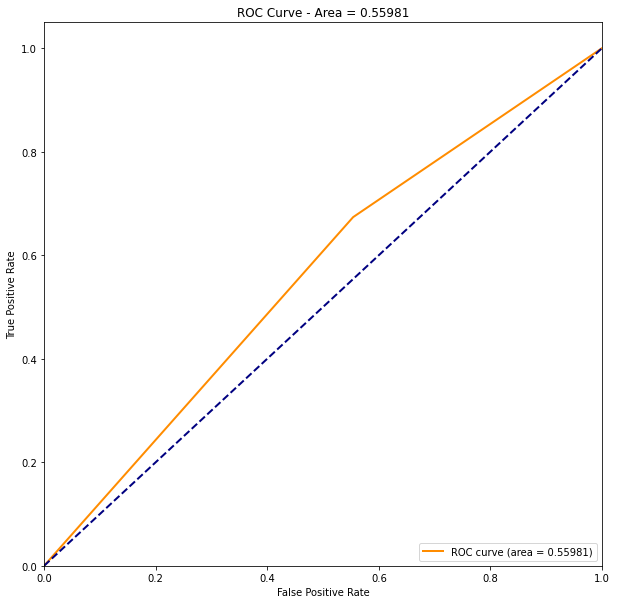

In [20]:
#Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(testy, pred) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Area = {:.5f}".format(roc_auc))
plt.legend(loc="lower right")
plt.show()

Then we try SVC and random forest to do the classification,the results are shown below:

In [21]:
# try SVC
sv =SVC(C=10, kernel='rbf', gamma='auto', coef0=0.0, shrinking=True, probability=False,
        decision_function_shape='ovr', break_ties=False, random_state=None)

sv_results = cross_validate(sv, Imbalance.drop(['betray'],axis=1), Imbalance['betray'], cv=5)
np.mean(sv_results['test_score'])

0.5303876942395228

In [22]:
# try random forest
rf= RandomForestClassifier(n_estimators=300,max_depth=22,criterion='gini')

rf_results = cross_validate(rf, Imbalance.drop(['betray'],axis=1), Imbalance['betray'], cv=5)
np.mean(rf_results['test_score'])

0.48336472557944854

We are not so satisfied with the predictive power, therefore, we think about predict betrayal with four seasons in a time line, that leads us to the second part of our experiment in part II.